# Traffic Signs Recognition using CNN & Keras

In this Python project example, we will build a deep neural network model that can classify traffic signs present in the image into different categories. With this model, we are able to read and understand traffic signs which are a very important task for all autonomous vehicles.

Our approach to building this traffic sign classification model is discussed in four steps:

- Explore the dataset
- Build a CNN model
- Train and validate the model
- Test the model with test dataset

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [2]:
import warnings
warnings.filterwarnings('ignore')

# The Dataset of Python Project

For this project, we are using the public dataset available at Kaggle:

[Traffic Signs Dataset](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/code)

The dataset contains more than 50,000 images of different traffic signs. It is further classified into 43 different classes. The dataset is quite varying, some of the classes have many images while some classes have few images. The size of the dataset is around 300 MB. The dataset has a train folder which contains images inside each class and a test folder which we will use for testing our model.

In [3]:
# loading dataset
data = []
labels = []
classes = 43
cur_path = '../Traffic Signs Recognition/Train'

for i in os.listdir(cur_path):
    dir_path = os.path.join(cur_path, i)

    for j in os.listdir(dir_path):
        img_path = os.path.join(dir_path, j)
        img = cv2.imread(img_path, -1)
        img = cv2.resize(img, (30, 30), interpolation=cv2.INTER_NEAREST)
        data.append(img)
        labels.append(i)

data = np.array(data)
labels = np.array(labels)
print(data.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


In [4]:
# Print shapes of data and labels
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, shuffle=True)

# Print shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Data shape: (39209, 30, 30, 3)
Labels shape: (39209,)
X_train shape: (31367, 30, 30, 3)
X_test shape: (7842, 30, 30, 3)
y_train shape: (31367,)
y_test shape: (7842,)


In [5]:
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

In [6]:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (31367, 43)
y_test shape: (7842, 43)


# Show Datasets in CSV Formet

In [7]:
train_data = pd.read_csv('../Traffic Signs Recognition/Train.csv')
test_data = pd.read_csv('../Traffic Signs Recognition/Test.csv')

train_data.rename({'ClassId':'label','Path':'path'},inplace=True,axis=1)
test_data.rename({'ClassId':'label','Path':'path'},inplace=True,axis=1)

train_data.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,label,path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [8]:
train_data = train_data.drop(['Roi.X1', 'Roi.Y1', 'Roi.X2','Roi.Y2'], axis=1)
test_data = test_data.drop(['Roi.X1', 'Roi.Y1', 'Roi.X2','Roi.Y2'], axis=1)

In [9]:
train_data.head()

,Width,Height,label,path
0,27,26,20,Train/20/00020_00000_00000.png
1,28,27,20,Train/20/00020_00000_00001.png
2,29,26,20,Train/20/00020_00000_00002.png
3,28,27,20,Train/20/00020_00000_00003.png
4,28,26,20,Train/20/00020_00000_00004.png


In [10]:
test_data.head()

,Width,Height,label,path
0,53,54,16,Test/00000.png
1,42,45,1,Test/00001.png
2,48,52,38,Test/00002.png
3,27,29,33,Test/00003.png
4,60,57,11,Test/00004.png


In [11]:
print('NO. of classes:', train_data['label'].nunique())

NO. of classes: 43


# Let's Visualize the testing Data

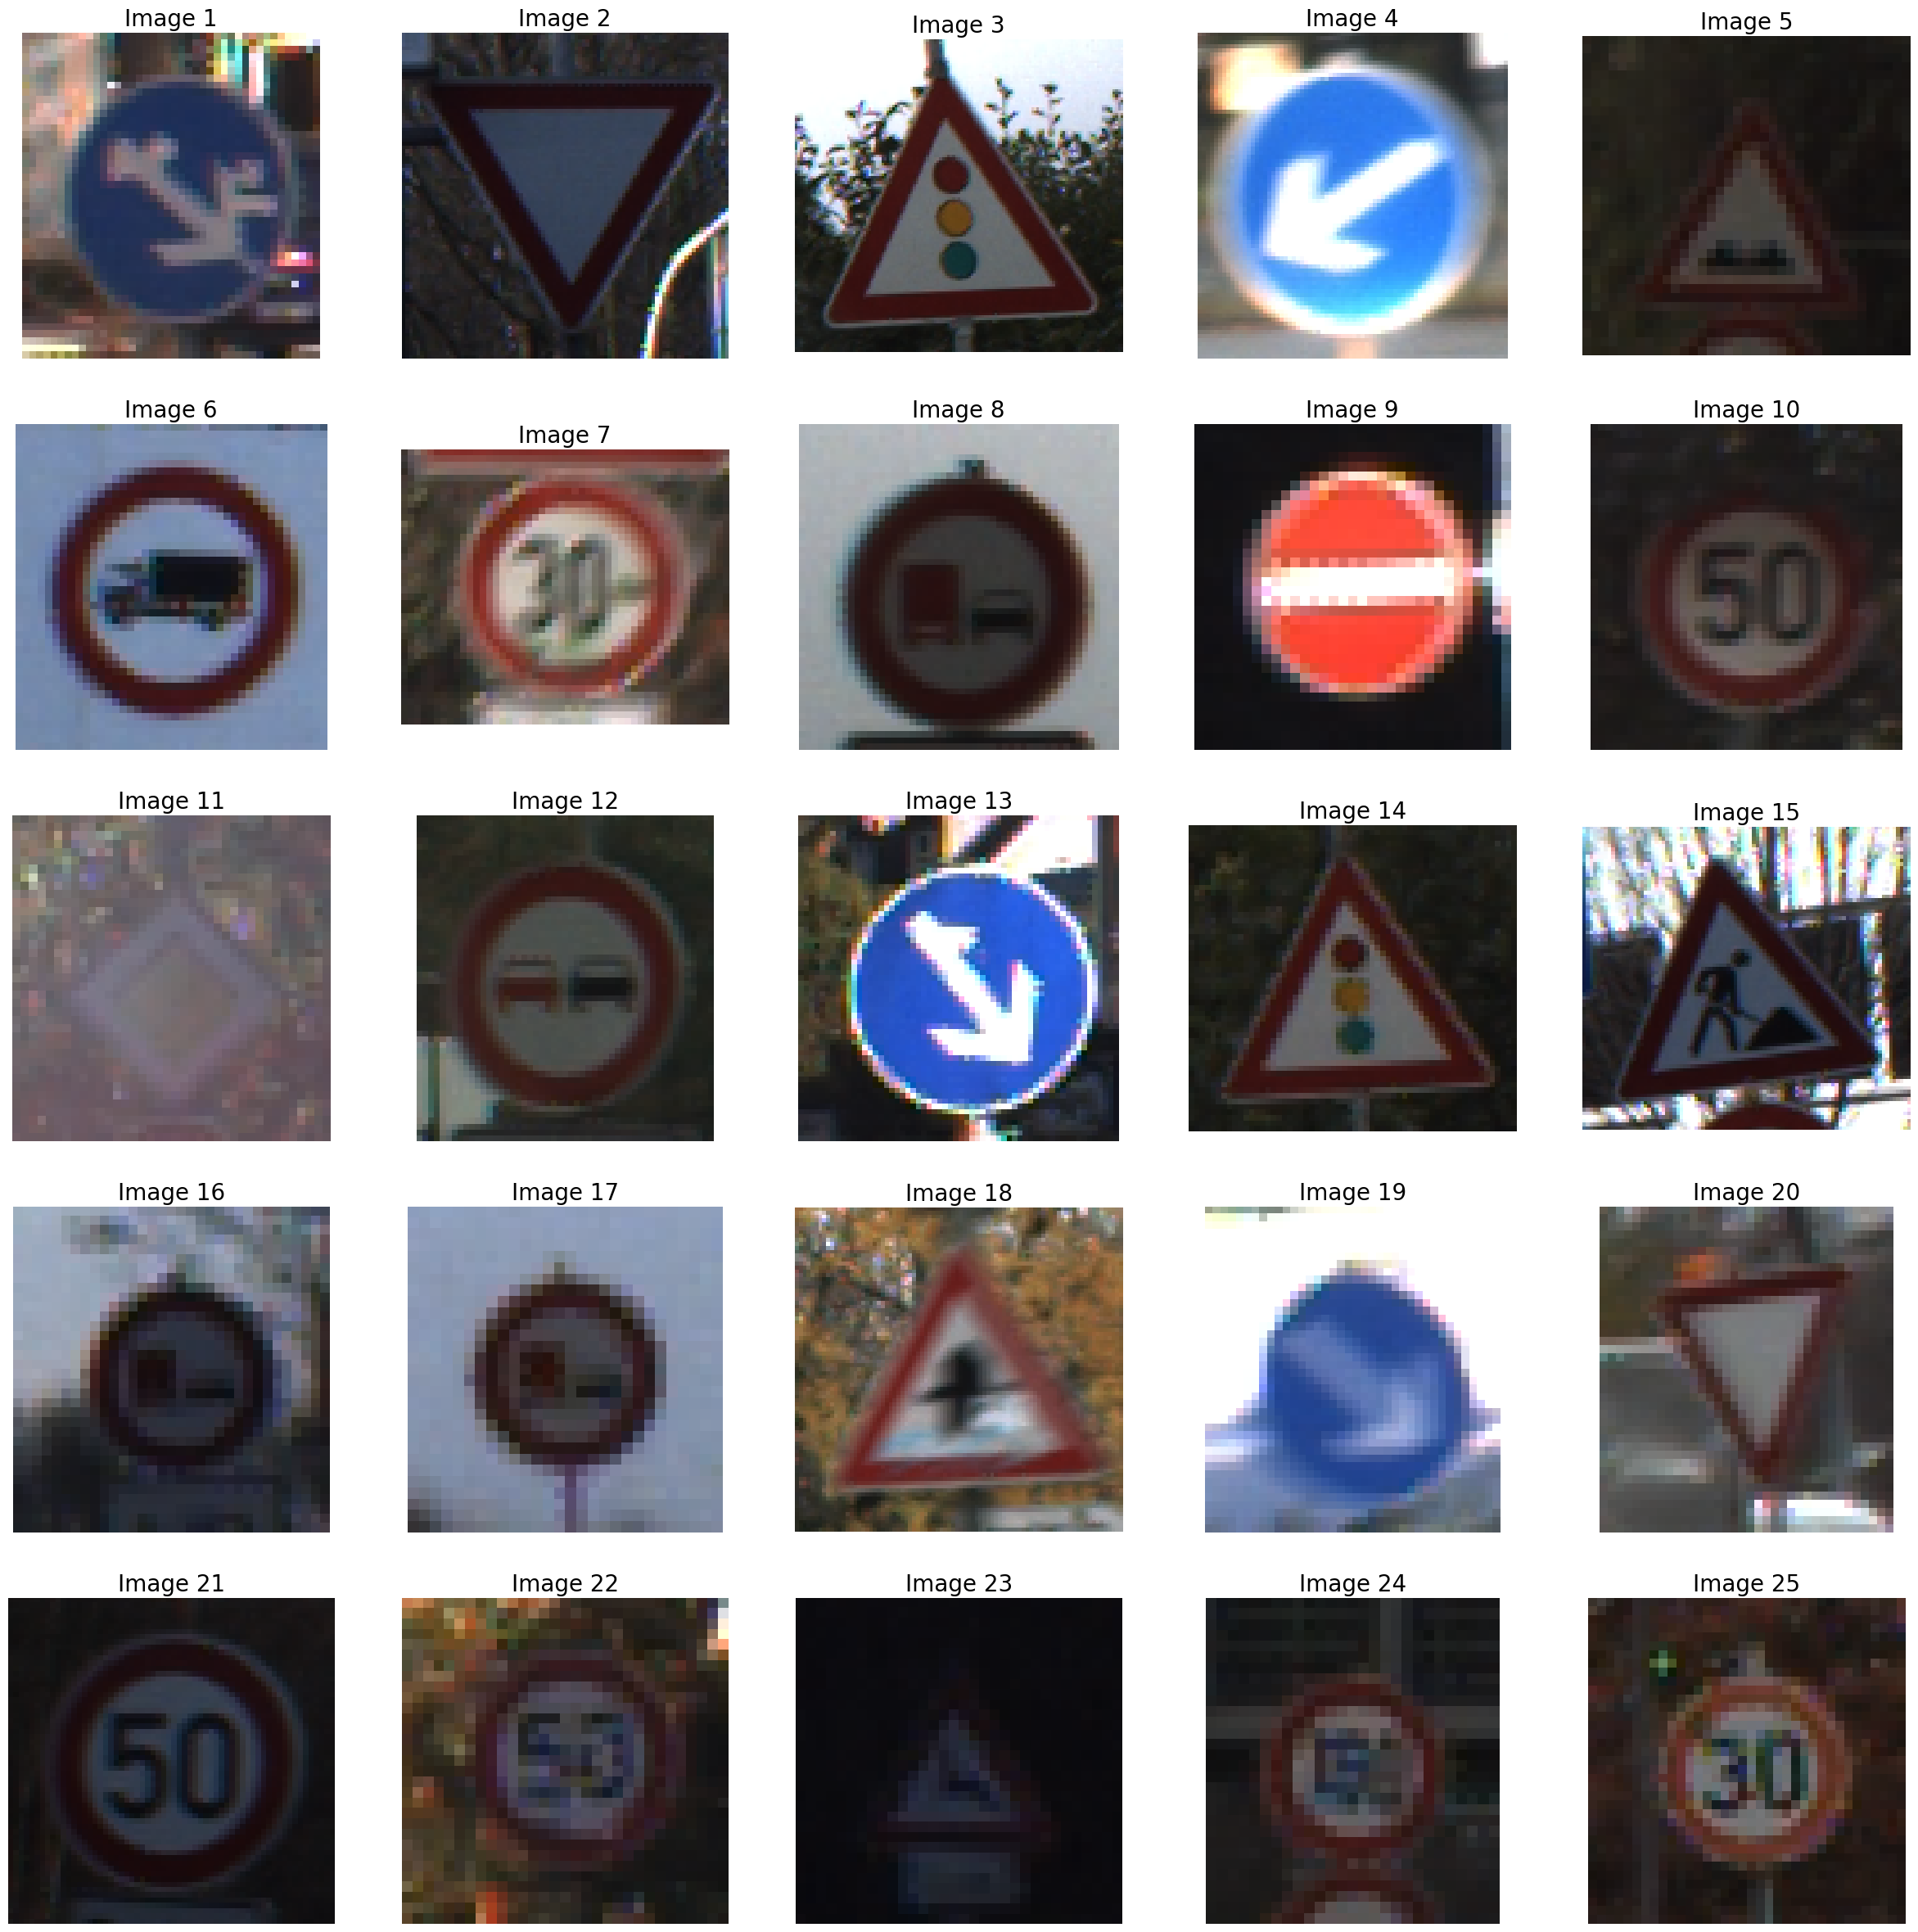

In [12]:
import random
from matplotlib.image import imread

data_dir= '../Traffic Signs Recognition'
imgs=test_data['path'].values
plt.figure(figsize=(30,30))

for i in range(1, 26):
    plt.subplot(5, 5, i)
    random_image_path = os.path.join(data_dir, random.choice(imgs))
    random_image = imread(random_image_path)
    plt.imshow(random_image)
    plt.axis('off')
    plt.title(f"Image {i}", fontsize=20)
    plt.xlabel(f"Width: {random_image.shape[1]}", fontsize=20)
    plt.ylabel(f"Height: {random_image.shape[0]}", fontsize=20)

# Let's Visualize the Training Datasets in Sorted grids formet

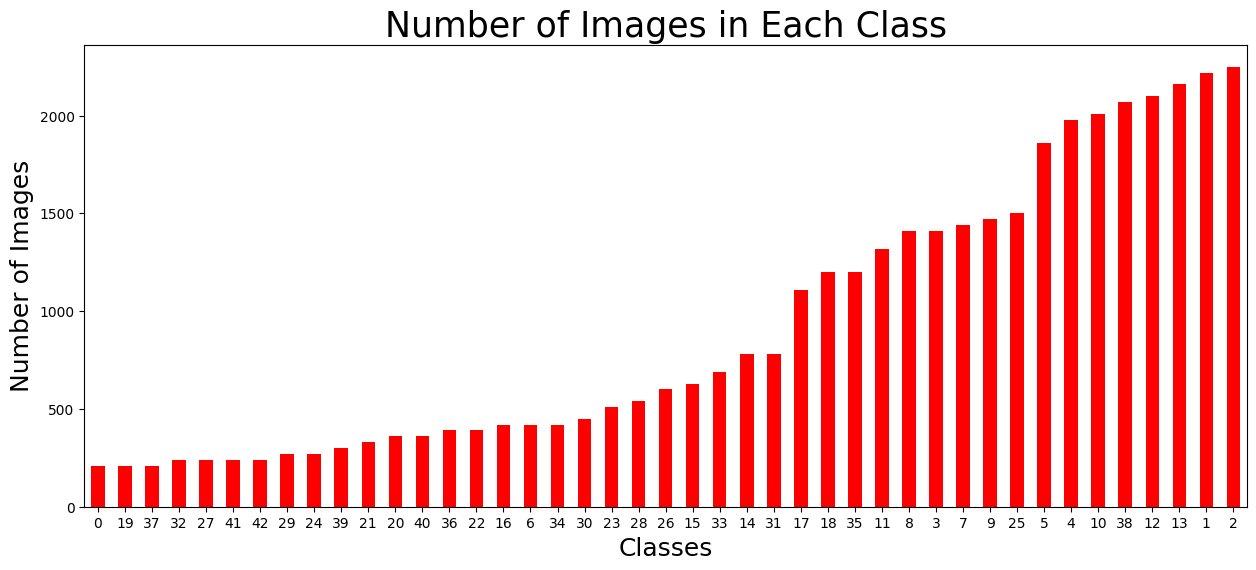

In [13]:
# Number of images in each class
data_dic = {}
for folder in os.listdir(cur_path):
    data_dic[folder] = len(os.listdir(os.path.join(cur_path, folder)))

data_series = pd.Series(data_dic)

data_series_sorted = data_series.sort_values()

# Plot the data
plt.figure(figsize=(15, 6))
data_series_sorted.plot(kind='bar', color='r')
plt.title('Number of Images in Each Class', fontsize=25)
plt.xlabel('Classes', fontsize=18)
plt.ylabel('Number of Images', fontsize=18)
plt.xticks(rotation=0, fontsize=10)
plt.show()

# Build a CNN model



In [14]:
# Initialize the model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Second Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 11, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          36928     
                                                        

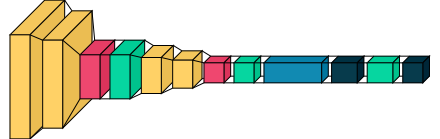

In [16]:
import visualkeras
visualkeras.layered_view(model)

# Callbacks 

In [17]:
filepath = 'Models\\best_model.epoch{epoch:02d}.h5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

callbacks = [checkpoint]

# Train and validate the model

In [18]:
# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

# Training the model
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/10
490/491 [============================>.] - ETA: 0s - loss: 2.2133 - accuracy: 0.4386
Epoch 1: val_loss improved from inf to 0.61676, saving model to models\best_model.epoch01.h5
491/491 [==============================] - 44s 89ms/step - loss: 2.2129 - accuracy: 0.4388 - val_loss: 0.6168 - val_accuracy: 0.8437
Epoch 2/10
490/491 [============================>.] - ETA: 0s - loss: 0.8158 - accuracy: 0.7626
Epoch 2: val_loss improved from 0.61676 to 0.26455, saving model to models\best_model.epoch02.h5
491/491 [==============================] - 42s 85ms/step - loss: 0.8157 - accuracy: 0.7626 - val_loss: 0.2646 - val_accuracy: 0.9232
Epoch 3/10
490/491 [============================>.] - ETA: 0s - loss: 0.5411 - accuracy: 0.8379
Epoch 3: val_loss improved from 0.26455 to 0.20068, saving model to models\best_model.epoch03.h5
491/491 [==============================] - 42s 85ms/step - loss: 0.5410 - accuracy: 0.8379 - val_loss: 0.2007 - val_accuracy: 0.9513
Epoch 4/10
490/491 [======

# Plotting graphs for accuracy 

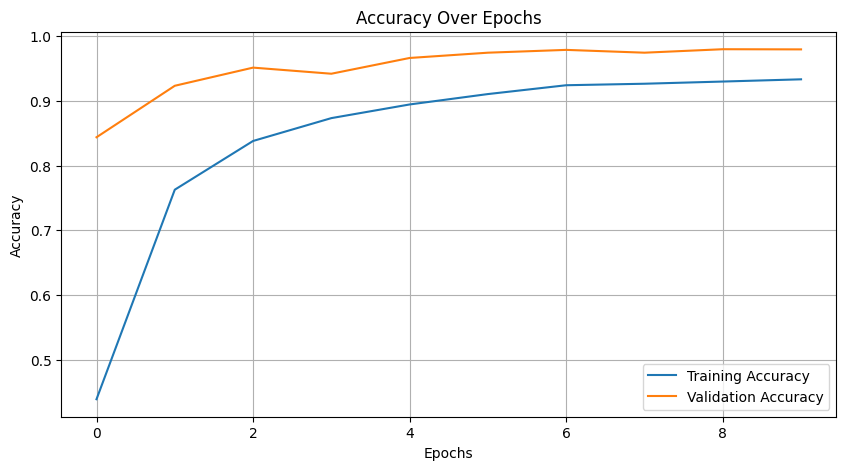

In [19]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

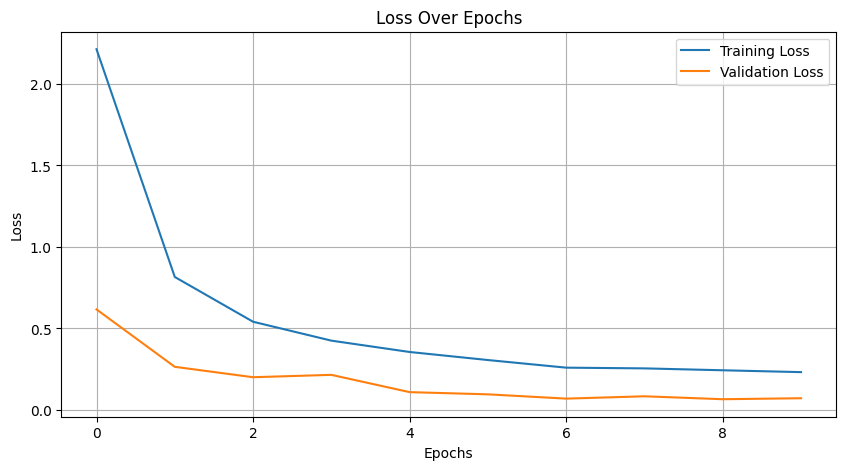

In [20]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Evalution


In [21]:
# Evaluate the model on the test dataset
score = model.evaluate(X_test, y_test, verbose=0)

# Print the test loss and test accuracy
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

Test Loss: 0.07183842360973358
Test Accuracy: 0.9794695377349854


In [22]:
# Make predictions on the test dataset
y_pred = model.predict(X_test)

# Convert one-hot encoded labels to class labels for both true labels and predicted labels
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

246/246 [==============================] - 2s 9ms/step


In [23]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate and print a classification report
print("Classification Report:")
print(classification_report(y_test_class, y_pred_class))

# Generate and print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_class, y_pred_class))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        38
           1       0.97      0.98      0.97       496
           2       0.99      0.94      0.96       420
           3       1.00      0.97      0.98       294
           4       0.99      0.97      0.98       400
           5       0.92      0.97      0.94       364
           6       1.00      1.00      1.00        69
           7       0.97      0.96      0.97       313
           8       0.93      1.00      0.96       274
           9       0.98      0.98      0.98       277
          10       0.99      1.00      0.99       398
          11       0.99      0.99      0.99       261
          12       1.00      1.00      1.00       443
          13       1.00      1.00      1.00       422
          14       1.00      0.99      0.99       135
          15       1.00      0.97      0.98       118
          16       1.00      0.98      0.99        86
    

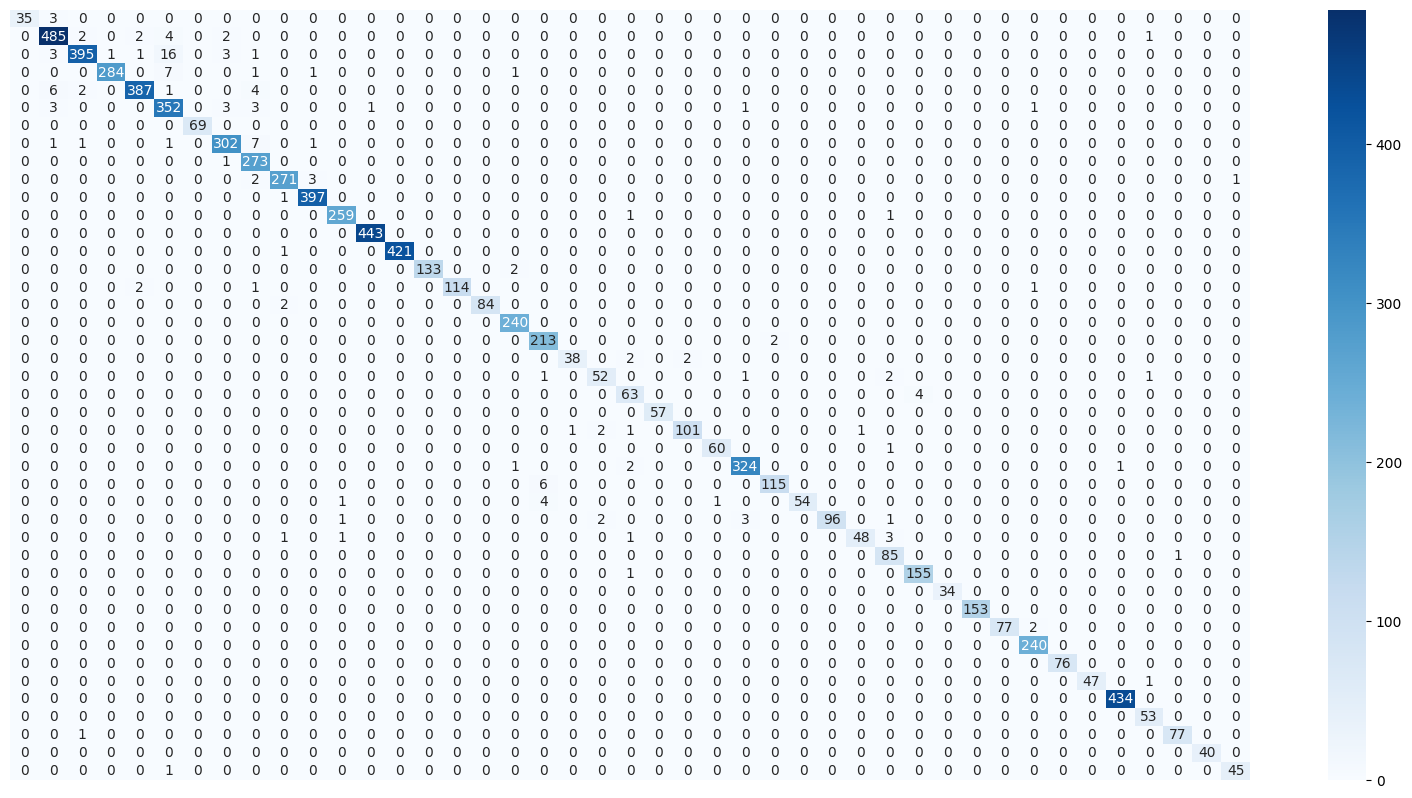

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test_class, y_pred_class)

# Create a heatmap of the confusion matrix with annotations
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=False, yticklabels=False)

# Save the heatmap as an image
plt.savefig('confusion_matrix.png')
plt.show()

In [25]:
# Calculate the Accuracy
from sklearn.metrics import accuracy_score

score=accuracy_score(y_pred_class,y_test_class)
score

0.9794695230808467

In [26]:
model.save('traffic_classifier.keras')

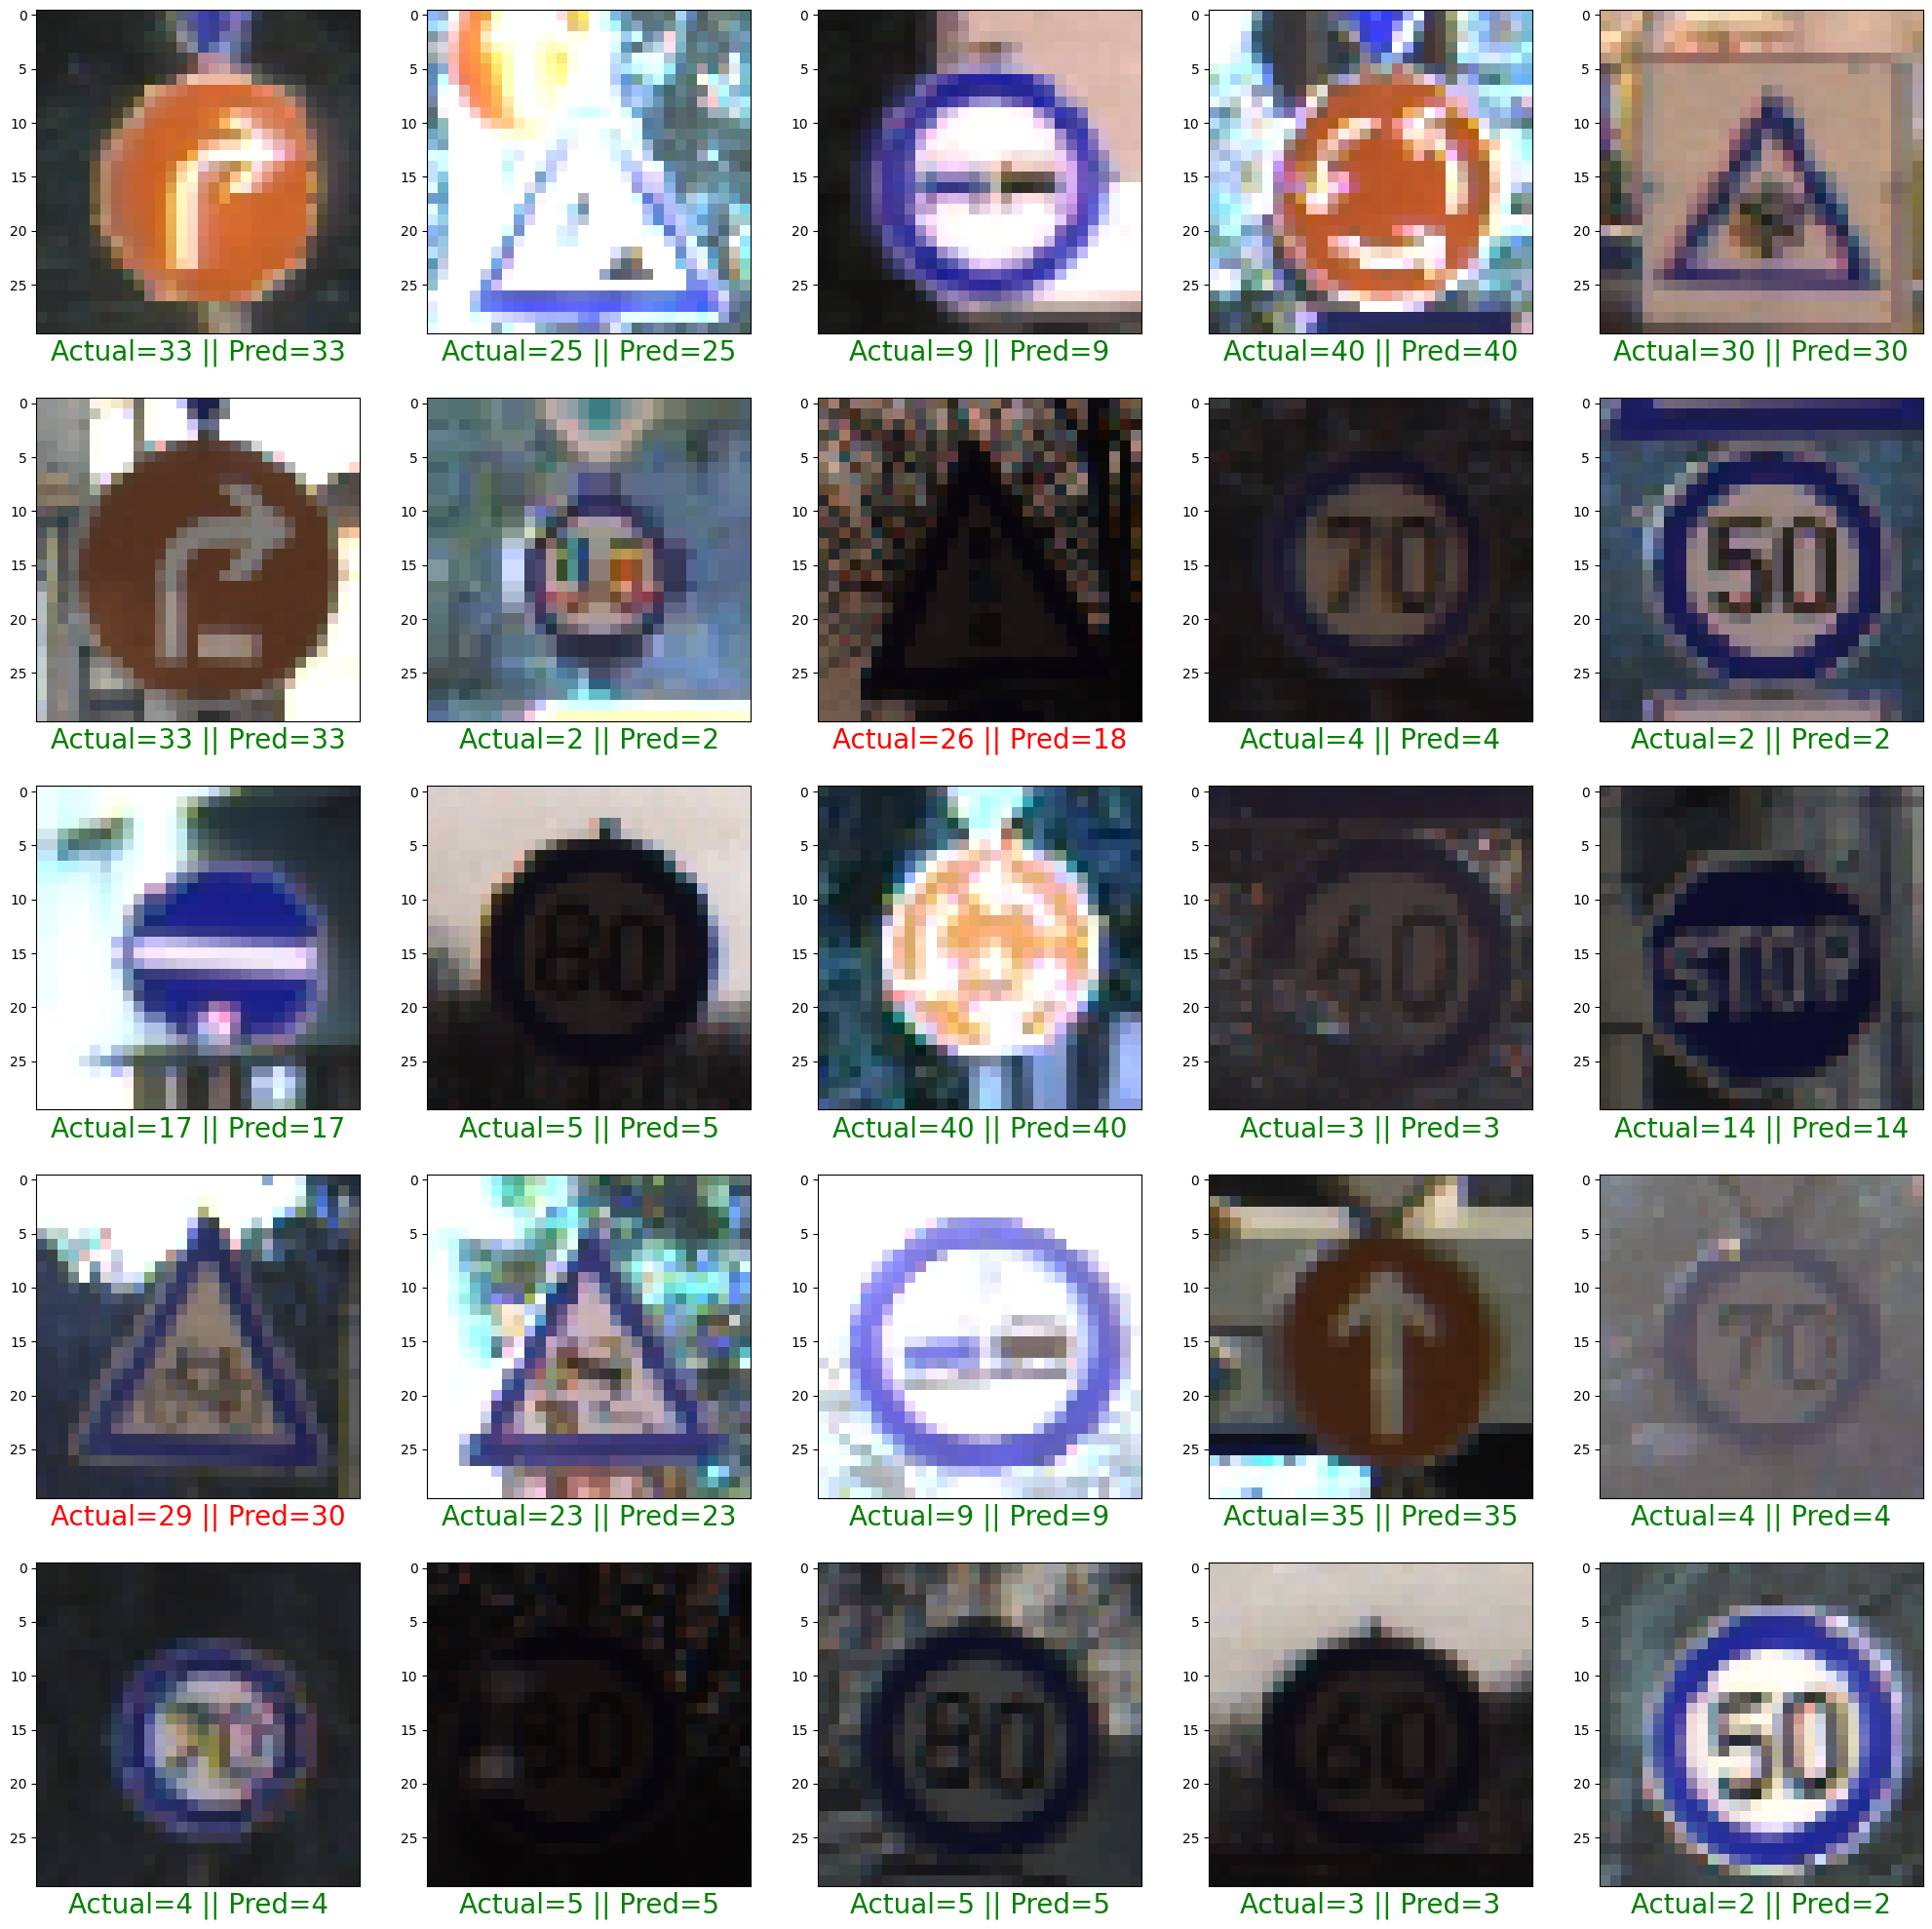

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Set the size of the figure
plt.figure(figsize=(25, 25))

# Randomly select 25 indices from the test dataset
random_indices = np.random.choice(len(X_test), 25, replace=False)

for i, index in enumerate(random_indices):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks()

    # Get the prediction and actual label
    prediction = y_pred_class[index]
    actual = y_test_class[index]

    # Check if the prediction matches the actual label using numpy.array_equal
    is_correct = np.array_equal(prediction, actual)

    # Set the label color based on whether the prediction is correct
    label_color = 'g' if is_correct else 'r'

    # Create a label for the image
    label_text = 'Actual={} || Pred={}'.format(actual, prediction)

    # Display the image with the label
    plt.xlabel(label_text, color=label_color, fontsize=20)
    plt.imshow(X_test[index])

plt.show()
